In [36]:
import numpy as np
from matplotlib import pyplot as plt
import mahotas
from tqdm import tqdm
from itertools import repeat
import os
from PIL import Image

In [2]:
def extract_patch(img, x, y, p):
    return img[x : x + p, y : y + p]

In [3]:
def extract_patch_zernike(img, x, y, p):
    return img[x, y, :]

In [4]:
def image_to_zernike(img, p):
    radius = p
    h, w = img.shape[0] - p, img.shape[1] - p
    img_zernike = np.zeros((h, w, 25))
    for x in range(h):
        for y in range(w):
            img_zernike[x, y] = mahotas.features.zernike_moments(img[x : x + p, y : y + p], radius)
    return img_zernike

In [5]:
def image_to_zernike_3c(img, p):
    return np.swapaxes(np.swapaxes(np.array([image_to_zernike(img[:,:,i], p) for i in range(3)]), 0,2), 0, 1)

In [6]:
def l1(p1, p2):
    return np.sum(abs(p1 - p2))

In [7]:
def l1_3c(p1, p2):
    return np.sum(abs(p1 - p2))

In [8]:
def propagation(img, nnf_x, nnf_y, odd, p, loss_fn=l1):
    h, w = img.shape[0], img.shape[1]
    if odd:
        for x in range(0, h-1):
            for y in range(0,w-1):
                best_d = nnf_x[x, y], nnf_y[x, y]
                best_l = loss_fn(extract_patch_zernike(img, x, y, p), extract_patch_zernike(img, x + nnf_x[x, y], y + nnf_y[x, y], p))
                if 0 <= x + nnf_x[x+1, y] < h and 0 <= y + nnf_y[x+1, y] < w and loss_fn(extract_patch_zernike(img, x, y, p), extract_patch_zernike(img, x + nnf_x[x+1, y], y + nnf_y[x+1, y], p)) < best_l:
                    best_l = loss_fn(extract_patch_zernike(img, x, y, p), extract_patch_zernike(img, x + nnf_x[x+1, y], y + nnf_y[x+1, y], p))
                    best_d = nnf_x[x+1, y], nnf_y[x+1, y]
                if 0 <= x + nnf_x[x, y+1] < h and 0 <= y + nnf_y[x, y+1] < w and loss_fn(extract_patch_zernike(img, x + best_d[0], y + best_d[1], p), extract_patch_zernike(img, x + nnf_x[x, y+1], y + nnf_y[x, y+1], p)) < best_l:
                    best_l = loss_fn(extract_patch_zernike(img, x, y, p), extract_patch_zernike(img, x + nnf_x[x, y+1], y + nnf_y[x, y+1], p))
                    best_d = nnf_x[x, y+1], nnf_y[x, y+1]
                nnf_x[x, y], nnf_y[x, y] = best_d
    else:
        for x in range(1, h):
            for y in range(1,w):
                best_d = nnf_x[x, y], nnf_y[x, y]
                best_l = loss_fn(extract_patch_zernike(img, x, y, p), extract_patch_zernike(img, x + nnf_x[x, y], y + nnf_y[x, y], p))
                if 0 <= x + nnf_x[x-1, y] < h and 0 <= y + nnf_y[x-1, y] < w and loss_fn(extract_patch_zernike(img, x, y, p), extract_patch_zernike(img, x + nnf_x[x-1, y], y + nnf_y[x-1, y], p)) < best_l:
                    best_l = loss_fn(extract_patch_zernike(img, x, y, p), extract_patch_zernike(img, x + nnf_x[x-1, y], y + nnf_y[x-1, y], p))
                    best_d = nnf_x[x-1, y], nnf_y[x-1, y]
                if 0 <= x + nnf_x[x, y-1] < h and 0 <= y + nnf_y[x, y-1] < w and loss_fn(extract_patch_zernike(img, x + best_d[0], y + best_d[1], p), extract_patch_zernike(img, x + nnf_x[x, y-1], y + nnf_y[x, y-1], p)) < best_l:
                    best_l = loss_fn(extract_patch_zernike(img, x, y, p), extract_patch_zernike(img, x + nnf_x[x, y-1], y + nnf_y[x, y-1], p))
                    best_d = nnf_x[x, y-1], nnf_y[x, y-1]
                nnf_x[x, y], nnf_y[x, y] = best_d
    return nnf_x, nnf_y
                                     
                                     
                                     
                                     
                                     

In [9]:
def random_search(img, nnf_x, nnf_y, p, L=5, loss_fn=l1):
    dir_random = [(-1,-1), (0,1), (1,0), (0,-1), (-1,0), (1,-1), (-1,1), (1,1)]
    h, w = img.shape[0], img.shape[1]
    for x in range(h):
        for y in range(w):
            best_d = nnf_x[x, y], nnf_y[x, y]
            best_l = loss_fn(extract_patch_zernike(img, x, y, p), extract_patch_zernike(img, x + nnf_x[x, y], y + nnf_y[x, y], p))
            for i in range(L):
                dir_ = dir_random[np.random.randint(8)]
                while not(0 <= x + nnf_x[x ,y] + 2 ** i * dir_[0] < h) or not(0 <= y + nnf_y[x ,y] + 2 ** i * dir_[1] < w) or (nnf_x[x ,y] + 2 ** i * dir_[0] == 0 and nnf_y[x ,y] + 2 ** i * dir_[1]==0):
                    dir_ = dir_random[np.random.randint(8)]
                if loss_fn(extract_patch_zernike(img, x, y, p), extract_patch_zernike(img, int(x + nnf_x[x, y] + 2 ** i * dir_[0]), int(y + nnf_y[x, y] + 2 ** i * dir_[1]), p)) < best_l:
                    best_d = nnf_x[x ,y] + 2 ** i * dir_[0], nnf_y[x ,y] + 2 ** i * dir_[1]
            nnf_x[x, y], nnf_y[x, y] = best_d
    return nnf_x, nnf_y
                
            

In [10]:
def symetry_comparison(img, nnf_x, nnf_y, p, loss_fn=l1):
    h, w = img.shape[0], img.shape[1]
    for x in range(h):
        for y in range(w):
            x_, y_ = x + nnf_x[x, y], y + nnf_y[x, y]
            best_l = loss_fn(extract_patch_zernike(img, x_, y_, p), extract_patch_zernike(img, x_ + nnf_x[x_, y_], y_ + nnf_y[x_, y_], p))
            if loss_fn(extract_patch_zernike(img, x_, y_, p), extract_patch_zernike(img, x, y, p)) < best_l:
                nnf_x[x_, y_] = - nnf_x[x, y]
                nnf_y[x_, y_] = - nnf_y[x, y]
    return nnf_x, nnf_y
            
            
            
            

In [11]:
def remove_0(nnf_x, nnf_y, p):
    for i in range(nnf_x.shape[0]):
        for j in range(nnf_x.shape[1]):
            while nnf_x[i,j] == nnf_y[i,j] == 0:
                nnf_x[i,j] = np.random.randint(-i, nnf_x.shape[0] - i - p)
    return nnf_x, nnf_y

In [12]:
def patchmatch(img, n_iters=100, p=8):
    img_zernike = image_to_zernike_3c(img, p)
    h, w = img.shape[0] - p, img.shape[1] - p
    x = np.array(np.linspace(0,h-1,h))
    y = np.array(np.linspace(0,w-1,w))
    yy, xx = np.meshgrid(y, x)
    xx = xx.astype(int)
    yy = yy.astype(int)
    nnf_x = np.random.randint(-xx, h-xx-p)
    nnf_y = np.random.randint(-yy, w-yy-p)
    nnf_x, nnf_y = remove_0(nnf_x, nnf_y, p) # to avoid null move
    for i in tqdm(range(n_iters)):
        nnf_x, nnf_y = propagation(img_zernike, nnf_x, nnf_y, i%2, p)
        nnf_x, nnf_y = symetry_comparison(img_zernike, nnf_x, nnf_y, p)
        nnf_x, nnf_y = random_search(img_zernike, nnf_x, nnf_y, p)
    return nnf_x, nnf_y

In [112]:
img = np.random.randint(0,256, size=(40,80,3))
img[1:18, 4:23] = img[15:32, 20:39] 
#img[1:20, 4:23] = np.rot90(img[15:34, 20:39])

In [113]:
image_to_zernike_3c(img, 8).shape

(32, 72, 3, 25)

In [114]:
nnf_x, nnf_y = patchmatch(img, 20, p=8)

100%|██████████| 20/20 [00:05<00:00,  3.37it/s]


In [115]:
nnf_x[2:10, 4:12]

array([[14, 14, 14,  0,  0, 14, 14, 14],
       [14, 14, 14, 14, 14, 14, 14, 14],
       [14, 14, 14, 14,  0, 14, 14, 14],
       [14, 14, 14, 14, 14, 14, 14, 14],
       [14, 14, 14, 14, 14, 14, 14, 14],
       [14, 14, 14, 14, 14, 14, 14, 14],
       [14, 14, 14, 14, 14, 14, 14, 14],
       [14, 14, 14, 14, 14, 14, 14, 14]])

In [49]:
#im = Image.open('images/train_.jpeg')
#im = Image.open('images/building_1.jpeg')
im = Image.open('images/lion_.jpeg')
#im = Image.open('images/missile.jpeg')
img = np.array(im)

In [50]:
img.shape

(150, 200, 3)

In [51]:
nnf_x, nnf_y = patchmatch(img, 20, p=8)

100%|██████████| 20/20 [01:02<00:00,  3.12s/it]


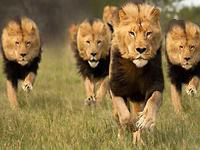

In [52]:
im

In [53]:
def diff_nn(img, nnf_x, nnf_y, p=8, loss_fn=l1):
    h, w = nnf_x.shape
    diff = np.zeros((h, w))
    img_zernike = image_to_zernike_3c(img, p)
    for x in range(h):
        for y in range(w):
            diff[x, y] = loss_fn(extract_patch_zernike(img_zernike, x, y, p), extract_patch_zernike(img_zernike, x + nnf_x[x, y], y + nnf_y[x, y], p))
    return diff      
    

In [54]:
diff = diff_nn(img, nnf_x, nnf_y, p=8)

In [31]:
h, w = diff.shape
img_copy = np.zeros((h, w, 3), dtype=int)

In [32]:
for x in range(diff.shape[0]):
    for y in range(diff.shape[1]):
        if diff[x, y] < 0.05:
            img_copy[x, y] = img[x,y]

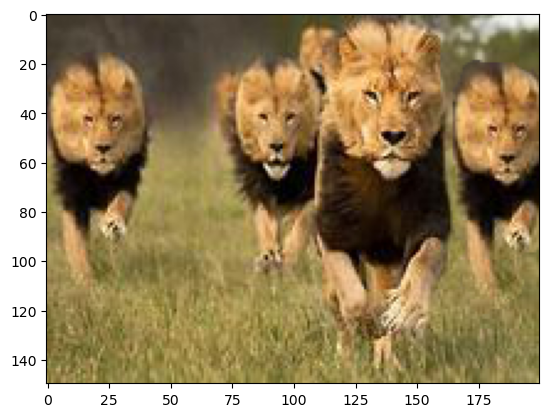

In [34]:
plt.imshow(img)

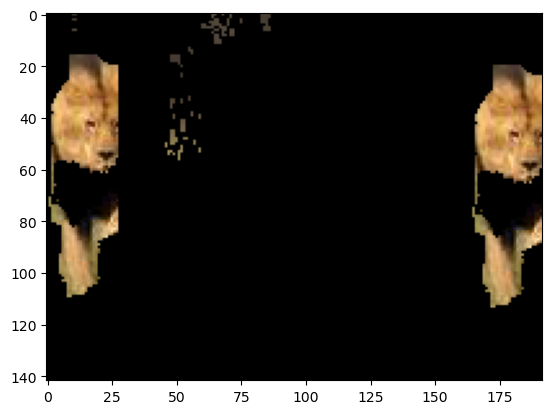

In [33]:
plt.imshow(img_copy)

100%|██████████| 40/40 [02:03<00:00,  3.08s/it]


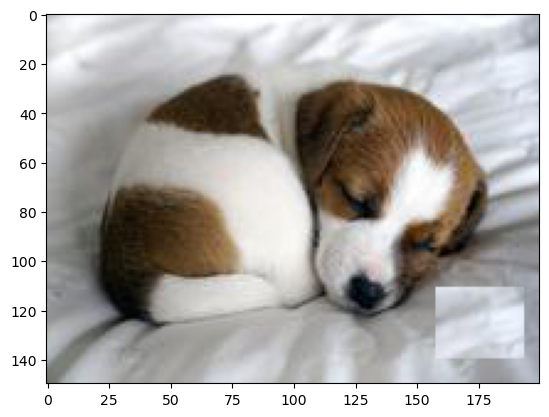

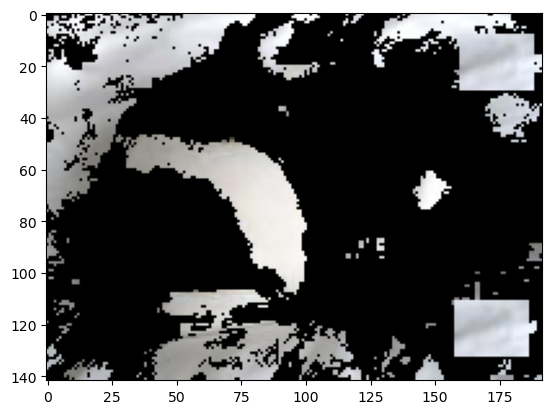

100%|██████████| 40/40 [01:59<00:00,  2.99s/it]


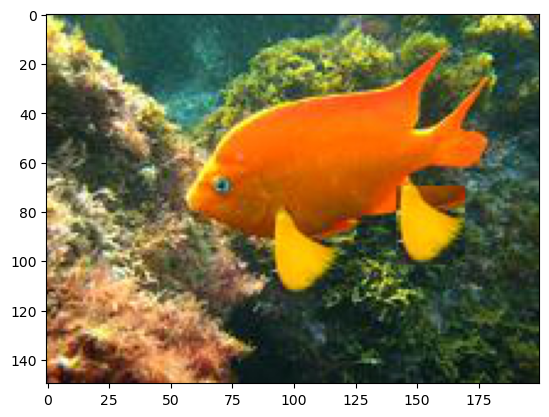

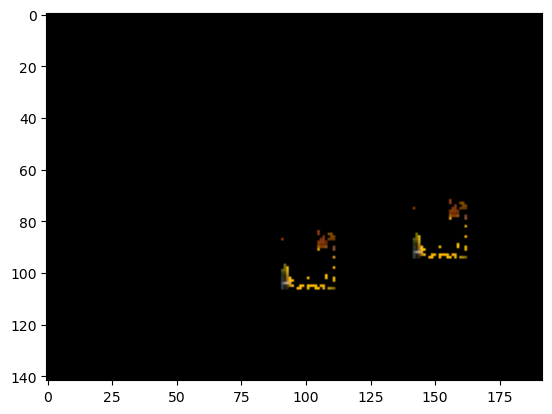

100%|██████████| 40/40 [01:59<00:00,  2.99s/it]


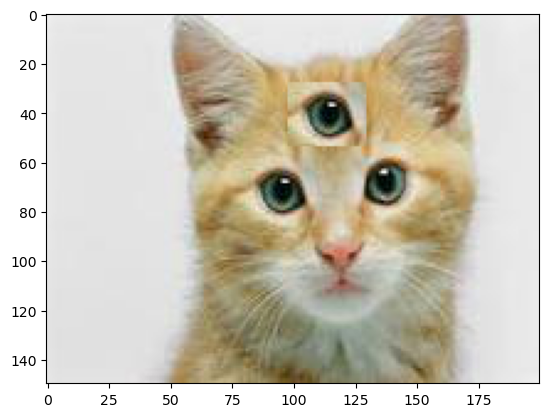

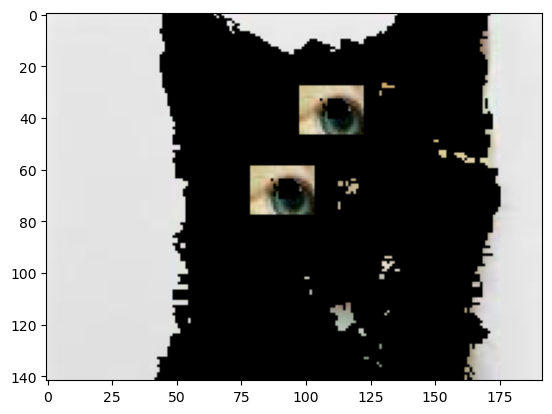

KeyboardInterrupt: 

In [140]:
arr = os.listdir('images')

for filename in arr[:-1]:
    im = Image.open('images/' + filename)
    img = np.array(im)
    nnf_x, nnf_y = patchmatch(img, 40, p=8)
    diff = diff_nn(img, nnf_x, nnf_y, p=8)
    h, w = diff.shape
    img_copy = np.zeros((h, w, 3), dtype=int)
    for x in range(diff.shape[0]):
        for y in range(diff.shape[1]):
            if diff[x, y] < 0.05:
                img_copy[x, y] = img[x,y]
    plt.imshow(img)
    plt.show()
    plt.imshow(img_copy)
    plt.show()

In [134]:
def std_patch(img, p=8):
    h, w = img.shape[0] - p, img.shape[1] - p 
    std = np.zeros((h,w))
    for x in range(h):
        for y in range(w):
            std[x, y] = np.mean(np.std(extract_patch(img, x, y, p), axis=(0,1)))
    return std

In [135]:
std = std_patch(img)

In [128]:
h, w = diff.shape
img_copy = np.zeros((h, w, 3), dtype=int)

In [129]:
for x in range(diff.shape[0]):
    for y in range(diff.shape[1]):
        if diff[x, y] * min(std[x,y], 3) < 0.1:
            img_copy[x, y] = img[x,y]

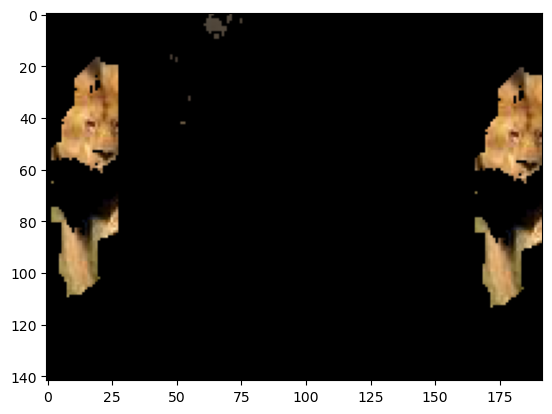

In [130]:
plt.imshow(img_copy)

100%|██████████| 40/40 [01:59<00:00,  2.98s/it]


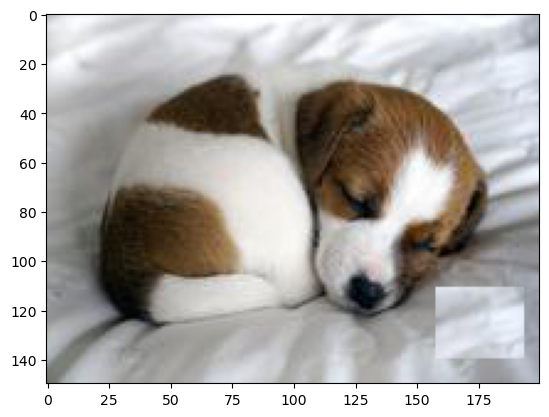

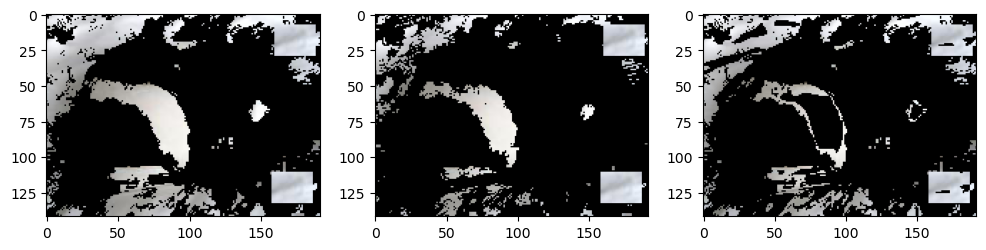

100%|██████████| 40/40 [01:59<00:00,  2.99s/it]


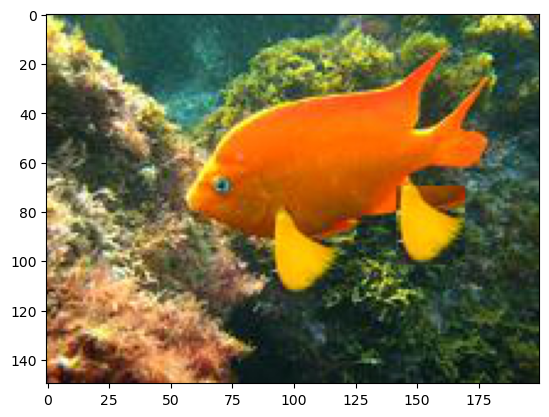

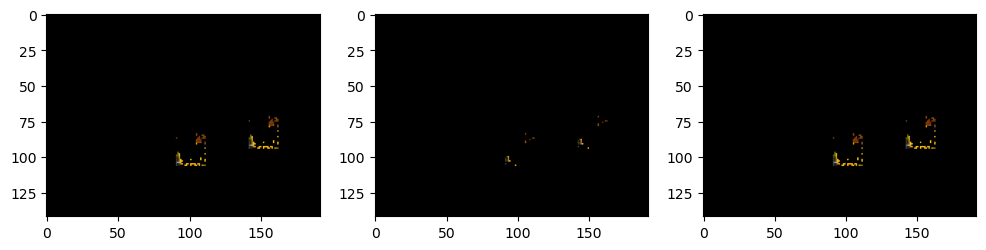

100%|██████████| 40/40 [02:01<00:00,  3.03s/it]


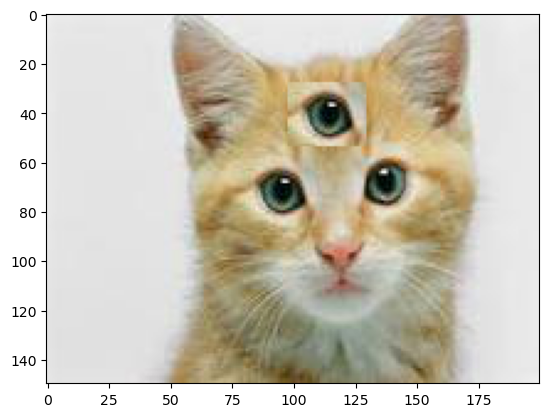

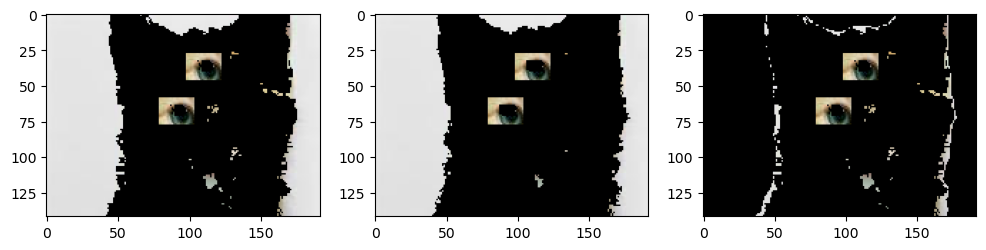

100%|██████████| 40/40 [02:04<00:00,  3.11s/it]


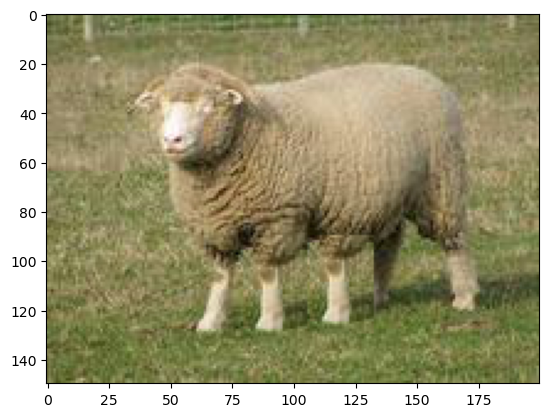

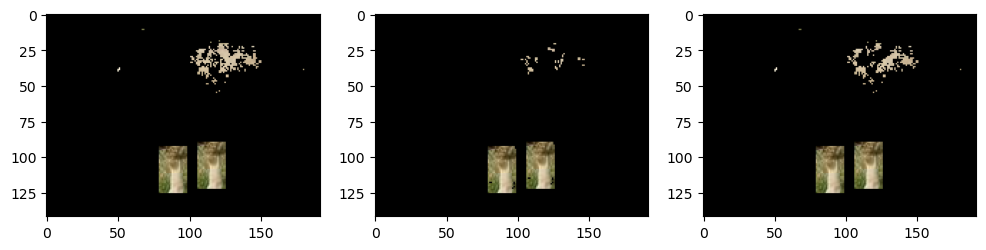

100%|██████████| 40/40 [02:02<00:00,  3.06s/it]


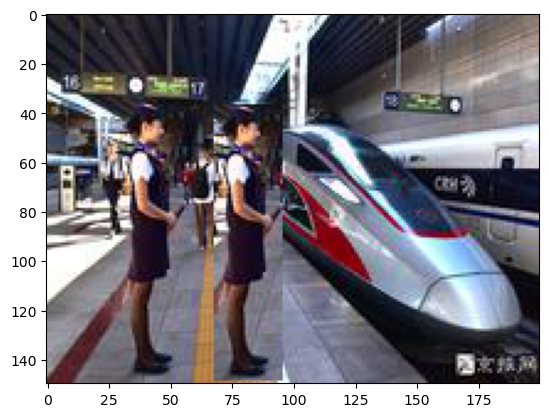

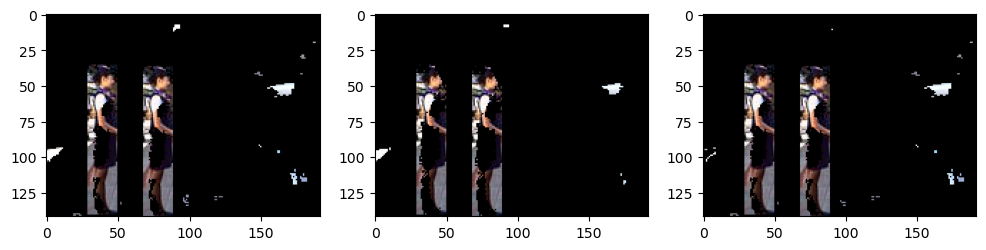

100%|██████████| 40/40 [02:00<00:00,  3.01s/it]


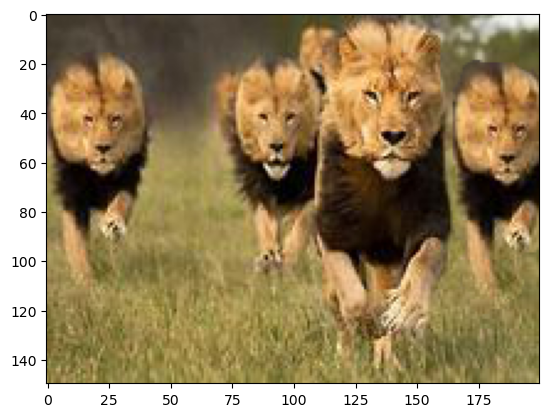

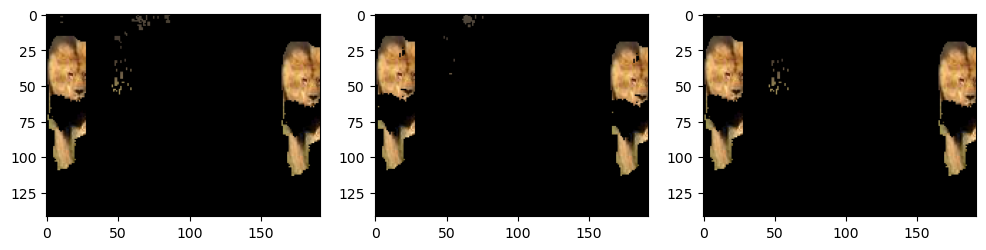

100%|██████████| 40/40 [02:00<00:00,  3.01s/it]


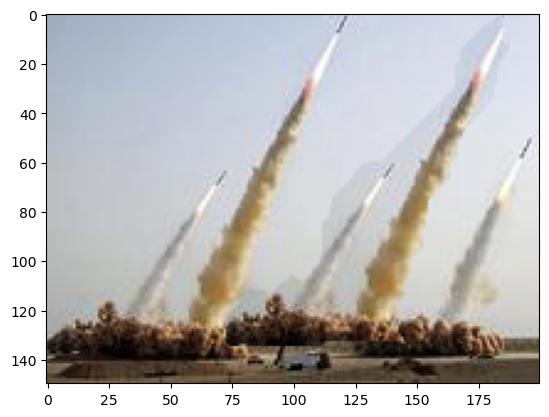

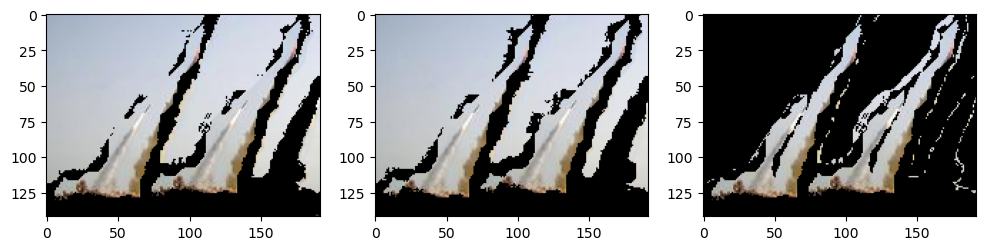

100%|██████████| 40/40 [02:01<00:00,  3.03s/it]


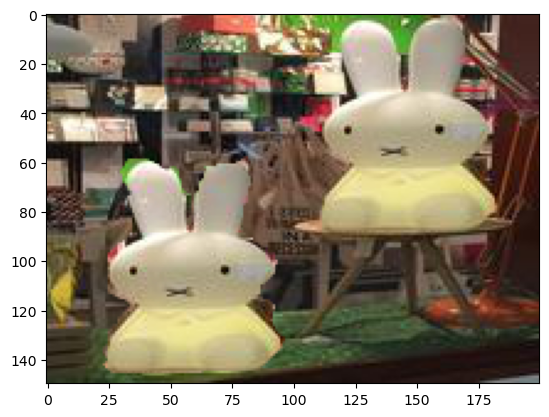

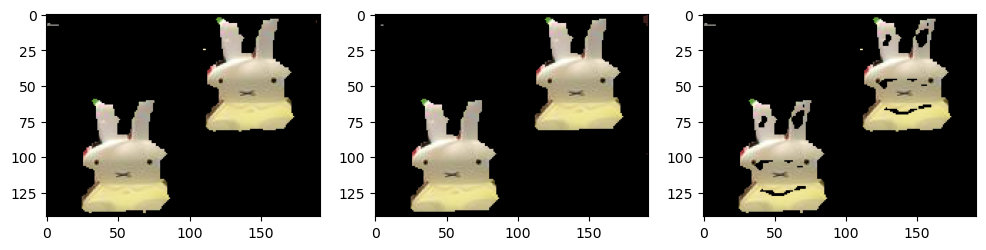

100%|██████████| 40/40 [02:01<00:00,  3.04s/it]


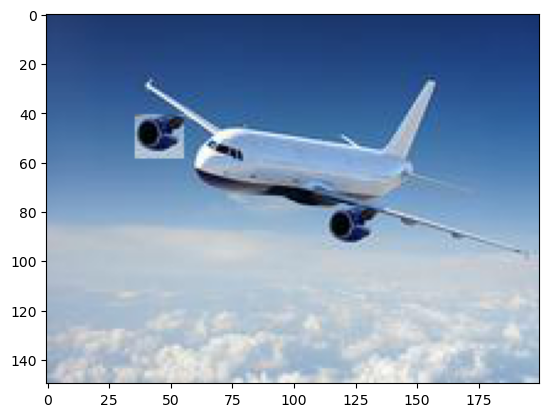

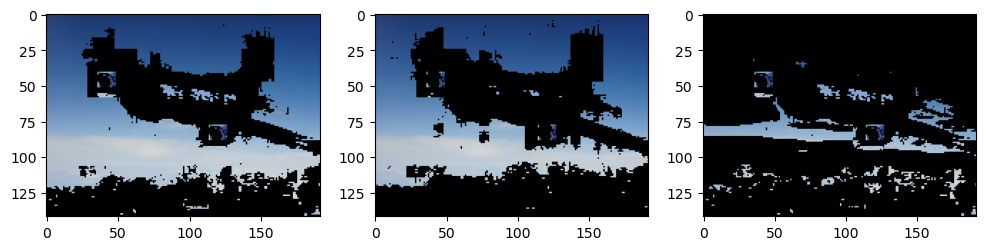

In [150]:
arr = os.listdir('images')

for filename in arr[:-1]:
    im = Image.open('images/' + filename)
    img = np.array(im)
    nnf_x, nnf_y = patchmatch(img, 40, p=8)
    diff = diff_nn(img, nnf_x, nnf_y, p=8)
    std = std_patch(img)
    h, w = diff.shape
    img_copy_1 = np.zeros((h, w, 3), dtype=int)
    img_copy_2 = np.zeros((h, w, 3), dtype=int)
    img_copy_3 = np.zeros((h, w, 3), dtype=int)
    for x in range(diff.shape[0]):
        for y in range(diff.shape[1]):
            if diff[x, y] < 0.05:
                img_copy_1[x, y] = img[x,y]
            if diff[x, y] * min(std[x,y], 3) < 0.1:
                img_copy_2[x, y] = img[x,y]
            if diff[x, y] < 0.05 and std[x,y] > 5:
                img_copy_3[x, y] = img[x,y]
    plt.imshow(img)
    plt.show()
    f, axarr = plt.subplots(1, 3, figsize=(12,8))
    axarr[0].imshow(img_copy_1)
    axarr[1].imshow(img_copy_2)
    axarr[2].imshow(img_copy_3)
    plt.show()